# 0. Setup
In this section, we import all necessary libraries and set up our environment for reproducibility and performance. We will:
Install and import required packages (e.g., scikit-learn, XGBoost, LightGBM, TensorFlow, Hugging Face Transformers, etc.).
Configure global settings, such as random seeds for reproducibility.
Detect hardware accelerators (GPU/TPU) and set computation device accordingly.
Define any global constants or configuration dictionaries (e.g., for preprocessing options, model toggles).


## 0.1 Installations

In [ ]:
!pip install gdown

In [ ]:
!pip install -q lightgbm xgboost transformers plotly gensim

## 0.2 Imports

In [ ]:
# Imports for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



# Imports for text preprocessing and NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import gensim.downloader as api
# Machine Learning models and utilities
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC as SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tqdm.notebook import tqdm

# Deep Learning (Keras and Transformers)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
# Other utilities
import os, sys, time
import logging
from sklearn.utils import class_weight

In [ ]:
# Downloads
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 0.3 Dataset Download
Our primary working environment for this coursework is in Google Collab.
 Storage in Google Colab primarily works on session storage or mounted google drives.
 This is very inconvenient we instead curl in the datasets for ease of **use**.

In [ ]:
# download dataset
!gdown --id 1pA7Mds0D_Y4hbBe8ShznH5rxWfds9nex -O amazon_reviews_complete.csv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1pA7Mds0D_Y4hbBe8ShznH5rxWfds9nex
From (redirected): https://drive.google.com/uc?id=1pA7Mds0D_Y4hbBe8ShznH5rxWfds9nex&confirm=t&uuid=3b2692a5-e140-4f2f-8dff-331b3ed3198e
To: /content/amazon_reviews_complete.csv
100% 136M/136M [00:00<00:00, 137MB/s]


In [ ]:
# download submission set
!gdown --id 1sHl5dIaPgICQyNZiCImmiU_wCBMHYMuI -O amazon_reviews_submission.csv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1sHl5dIaPgICQyNZiCImmiU_wCBMHYMuI
To: /content/amazon_reviews_submission.csv
100% 53.3M/53.3M [00:00<00:00, 106MB/s]


## 0.4 Environment Configuration

In [ ]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Check for GPU availability and set device
USE_GPU = False
device = "cpu"
if tf.config.list_physical_devices('GPU'):
    USE_GPU = True
    device = "GPU"
elif tf.config.list_physical_devices('TPU'):
    device = "TPU"
print(f"Running on {device}")

# Configuration for text preprocessing
PREPROCESS_CONFIG = {
    "lowercase": True,
    "remove_html": True,
    "remove_markdown": True,
    "remove_stopwords": True,
    "lemmatize": False,
    "stem": False   # Note: Use either lemmatize or stem, not both simultaneously for best results.
}

# Optionally sample a fraction of data for quicker runs (set to None or 1.0 to use full data)
SAMPLING_FRACTION = None  # e.g., 0.1 for 10% sample, or None to use all data

# Toggle for class imbalance handling
BALANCE_CLASSES = True  # if True, models that support class_weight will use it, or we may oversample in preprocessing

# Path to dataset
DATA_PATH = "amazon_reviews_complete.csv"


if USE_GPU:
    # For TensorFlow
    if device == "GPU":
        tf.config.optimizer.set_jit(True)  # Enable XLA compilation
        tf.config.set_soft_device_placement(True)
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)

    # For PyTorch (Transformers)
    torch.backends.cudnn.benchmark = True
    torch.autograd.profiler.emit_nvtx(False)
    torch.autograd.profiler.profile(False)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.get_logger().setLevel('INFO')

Running on GPU


Configurable options for preprocessing and modeling: We define dictionaries to control behavior of various pipeline stages. For example:
PREPROCESS_CONFIG: toggles for text cleaning (lowercasing, removing HTML/markdown, stopwords, lemmatization, stemming).
SAMPLING_FRACTION: fraction of data to sample for faster execution (if needed for large datasets).
BALANCE_CLASSES: whether to apply class balancing techniques (e.g., class weights in models).

# 1. Data Loading and Sampling
Here we load the Amazon food reviews dataset and prepare it for analysis. The dataset is expected at the path 'amazon_reviews_complete.csv' and contains at least two columns:
- Text: The review text content.
- Score: The rating (1 to 5 stars) given to the product.
Steps in this section:
- Read the CSV data into a pandas DataFrame.
- If SAMPLING_FRACTION is set (for performance), sample that fraction of the data randomly to reduce size.
- Display basic information: number of reviews, columns, and a preview of the data.
- Check distribution of the target Score (class imbalance insight).

In [ ]:
# Load the dataset
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError as e:
    print(f"Error: {e}\nPlease ensure the dataset is available at {DATA_PATH}")

# Optionally sample the data for faster computation (especially if dataset is very large)
if SAMPLING_FRACTION is not None and 0 < SAMPLING_FRACTION < 1.0:
    df = df.sample(frac=SAMPLING_FRACTION, random_state=SEED).reset_index(drop=True)

# Basic dataset info
print(f"Total reviews loaded: {len(df)}")
print("Columns:", df.columns.tolist())
print(df.head(3))


Total reviews loaded: 309131
Columns: ['Score', 'Text']
   Score                                               Text
0      5  I received this product early from the seller!...
1      5  *****<br />Numi's Collection Assortment Melang...
2      5  I was very careful not to overcook this pasta,...


Next, let's examine the distribution of review scores to understand class imbalance. If one score dominates (e.g., many 5-star reviews), we'll need to address that in modeling (using class weights or resampling).

Review score distribution:
  Score 1: 28521 reviews
  Score 2: 16287 reviews
  Score 3: 23296 reviews
  Score 4: 43876 reviews
  Score 5: 197151 reviews


<ipython-input-9-0c379968489f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=score_counts.index, y=score_counts.values, palette="viridis")


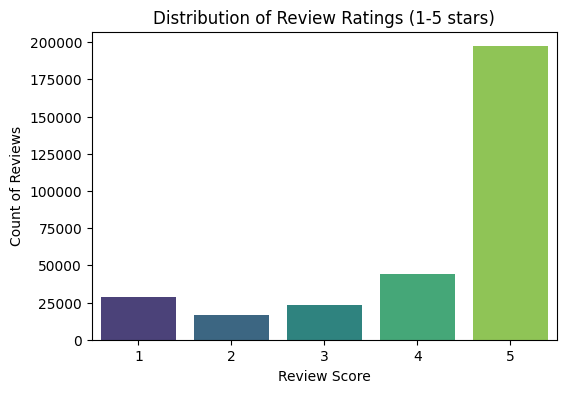

In [ ]:
# Check class distribution
score_counts = df['Score'].value_counts().sort_index()
print("Review score distribution:")
for score, count in score_counts.items():
    print(f"  Score {score}: {count} reviews")

# Visualize the class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=score_counts.index, y=score_counts.values, palette="viridis")
plt.title("Distribution of Review Ratings (1-5 stars)")
plt.xlabel("Review Score")
plt.ylabel("Count of Reviews")
plt.show()

# 2. Exploratory Data Analysis (EDA) with Visualizations
In this section, we perform exploratory analysis to gain insights from the text data and ratings:
- Review Text Lengths: Analyze the distribution of review lengths (number of words or characters).
- Common Words or N-grams: Identify frequent words in positive vs negative reviews.
- Interactive/3D Visualization: We create an interactive 3D scatter plot of reviews in a reduced feature space (using text embeddings or TF-IDF with dimensionality reduction) to see if reviews cluster by rating.

First, let's look at review lengths to understand how long the reviews typically are.

Review text length (words) - mean: 79.75595459530102 | median: 57.0 | max: 3432


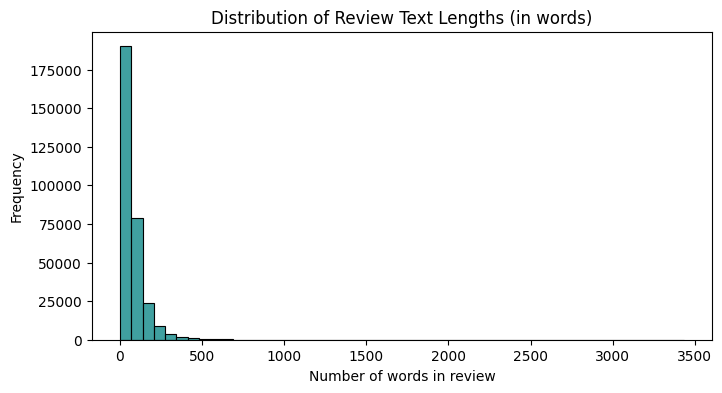

In [ ]:
# Compute review text lengths (number of words per review)
review_lengths = df['Text'].astype(str).apply(lambda x: len(x.split()))
# Summary statistics
print("Review text length (words) - mean:", review_lengths.mean(),
      "| median:", review_lengths.median(),
      "| max:", review_lengths.max())

# Plot distribution of review lengths
plt.figure(figsize=(8,4))
sns.histplot(review_lengths, bins=50, color='teal')
plt.title("Distribution of Review Text Lengths (in words)")
plt.xlabel("Number of words in review")
plt.ylabel("Frequency")
plt.show()

We can also check if longer reviews tend to have higher or lower ratings, by looking at average length per rating:

In [ ]:
# Average review length by rating
avg_len_by_score = df.groupby('Score')['Text'].apply(lambda texts: np.mean([len(str(t).split()) for t in texts]))
print("Average review length by score:")
for score, avg_len in avg_len_by_score.items():
    print(f"  Score {score}: {avg_len:.1f} words on average")

Average review length by score:
  Score 1: 82.7 words on average
  Score 2: 90.1 words on average
  Score 3: 96.0 words on average
  Score 4: 91.9 words on average
  Score 5: 73.9 words on average


Now, let's explore the vocabulary. For a quick insight, we'll look at the most common words in 5-star reviews vs 1-star reviews (after basic cleaning) to see how they differ.

In [ ]:
# Quick text normalization for analysis (lowercase and remove basic punctuation for word frequency)
def simple_tokenize(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    return tokens

# Get tokens for 5-star and 1-star reviews
tokens_5 = []
tokens_1 = []
for score, text in zip(df['Score'], df['Text']):
    if score == 5:
        tokens_5.extend(simple_tokenize(text))
    elif score == 1:
        tokens_1.extend(simple_tokenize(text))

# Count common tokens in each
from collections import Counter
common_5 = Counter(tokens_5).most_common(10)
common_1 = Counter(tokens_1).most_common(10)
print("Most common words in 5-star reviews:", common_5)
print("Most common words in 1-star reviews:", common_1)

Most common words in 5-star reviews: [('the', 565015), ('i', 536785), ('and', 444679), ('a', 398759), ('it', 350563), ('to', 326016), ('of', 245447), ('is', 242587), ('this', 224745), ('br', 191969)]
Most common words in 1-star reviews: [('the', 106148), ('i', 94554), ('and', 60582), ('it', 54163), ('to', 52895), ('a', 52863), ('of', 42881), ('this', 39721), ('is', 33031), ('br', 32615)]


We see some frequent words. (Note: Many common words could be generic or stopwords, which we will handle in preprocessing later.) Now, for an interactive 3D visualization, let's represent a sample of reviews in a vector space. We'll use TF-IDF to get numerical features and then reduce to 3 dimensions with Truncated SVD (similar to PCA for sparse data). Finally, we'll plot these points in 3D with Plotly, coloring by review score.

In [ ]:
# Create a 3D plot of review vectors reduced via SVD
sample_size = 1000  # number of points to sample for visualization
df_sample = df.sample(n=sample_size, random_state=SEED) if len(df) > 1000 else df.copy()

# Compute TF-IDF vectors for the sample
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')  # using English stopwords for vectorization
sample_tfidf = tfidf.fit_transform(df_sample['Text'].astype(str))

# Dimensionality reduction to 3 components
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=3, random_state=SEED)
sample_3d = svd.fit_transform(sample_tfidf)

# Prepare a DataFrame for plotting
plot_df = pd.DataFrame(sample_3d, columns=['x','y','z'])
plot_df['Score'] = df_sample['Score'].values

# 3D scatter plot with Plotly
fig = px.scatter_3d(plot_df, x='x', y='y', z='z', color=plot_df['Score'].astype(str),
                    title="3D Visualization of Review Embeddings by Rating",
                    labels={"color": "Score"})
fig.update_traces(marker=dict(size=5))
fig.show()

# 3. Preprocessing Pipeline
To prepare the text for modeling, we need a robust preprocessing pipeline. We will:
- Normalize text case: Convert to lowercase (if enabled).
- Remove HTML tags: Some reviews may contain HTML or markup, which we strip out.
- Remove Markdown/URLs: If any markdown formatting or URLs exist, remove them.
- Remove special characters/punctuation: Keep only letters (and optionally numbers if needed; here primarily letters to focus on words).
- Tokenize and remove stopwords: Remove common words that may not contribute to sentiment (optional, based on config).
- Lemmatize/Stemming: Reduce words to their base form (lemma) or root form (stem) to reduce sparsity (optional, based on config).


We'll implement a clean_text function that applies these steps according to PREPROCESS_CONFIG. This allows easy toggling of each step.

In [ ]:
# Ensure NLTK resources are available
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)

# Preprocessing function
def clean_text(text, config=PREPROCESS_CONFIG):
    """Clean text according to the configuration dictionary."""
    if not isinstance(text, str):
        text = str(text) if text is not None else ""
    # Lowercasing
    if config.get("lowercase", False):
        text = text.lower()
    # Remove HTML tags
    if config.get("remove_html", False):
        text = re.sub(r'<[^>]+>', ' ', text)
    # Remove markdown links (e.g., [text](url)) and other markdown special chars
    if config.get("remove_markdown", False):
        # Remove link markdown format
        text = re.sub(r'\[.*?\]\(.*?\)', ' ', text)
        # Remove residual markdown symbols like *, _, `
        text = re.sub(r'[\*_`]', ' ', text)
    # Remove non-alphabet characters (keeping spaces)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords if enabled
    if config.get("remove_stopwords", False):
        stop_words = set(stopwords.words('english'))
        # (Optional consideration: we might remove 'not' from stop_words to keep negation)
        if 'not' in stop_words:
            stop_words.remove('not')
        tokens = [word for word in tokens if word not in stop_words]
    # Apply lemmatization or stemming if enabled
    if config.get("lemmatize", False):
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    if config.get("stem", False):
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    # Join tokens back to string
    return " ".join(tokens)


Now we'll apply this cleaning to the text data. To avoid data leakage, we will fit any vocabulary-based processing (like removing stopwords or lemmatization) globally since those do not require fitting on training data specifically. Cleaning can be done for all sets, but we must be careful not to use future (test) data in any learned transformation. Here, cleaning is a stateless operation so it's safe to apply to all. We'll proceed to split the data into training and testing sets (and a validation set) before applying transformations that involve fitting (like vectorizers).

In [ ]:
# Split data into train, validation, and test sets
# We will simulate a Kaggle scenario: use a portion as "test" (to submit predictions for)
train_full_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Score'], random_state=SEED)
train_df, val_df = train_test_split(train_full_df, test_size=0.1, stratify=train_full_df['Score'], random_state=SEED)

print(f"Train set: {len(train_df)} reviews, Validation set: {len(val_df)} reviews, Test set: {len(test_df)} reviews")

# Apply text cleaning to train, val, test
train_df['clean_text'] = train_df['Text'].apply(lambda x: clean_text(x, PREPROCESS_CONFIG))
val_df['clean_text'] = val_df['Text'].apply(lambda x: clean_text(x, PREPROCESS_CONFIG))
test_df['clean_text'] = test_df['Text'].apply(lambda x: clean_text(x, PREPROCESS_CONFIG))


Train set: 222573 reviews, Validation set: 24731 reviews, Test set: 61827 reviews


After cleaning, let's verify the transformation on a sample of the text:

In [ ]:
# before-and-after example of cleaning
print("Original review example:\n", train_df['Text'].iloc[0])
print("\nCleaned review example:\n", train_df['clean_text'].iloc[0])

Original review example:
 Just like the previous 2-pack listing for this product which was removed, this is just TOO EXPENSIVE.  You can buy it at retail (Starbucks, Target, etc.) for around $7.  I absolutely love this tea - it's by far my favorite - but I'm unwilling to buy it through Amazon at these prices.

Cleaned review example:
 like previous pack listing product removed expensive buy retail starbucks target etc around absolutely love tea far favorite unwilling buy amazon prices


We now have a new column 'clean_text' that contains the normalized and tokenized review text, ready for feature extraction.

_(We chose to remove stopwords and perform lemmatization by default. This helps reduce noise and dimensionality. However, we kept negation words like "not" in the text because they carry sentiment information.)_

#5. Feature Engineering

With cleaned text, the next step is to convert words into numerical features that models can use. We will implement a flexible feature engineering pipeline that can produce features using various approaches:
- Bag-of-Words (CountVectorizer): Converts text to high-dimensional sparse vectors of word counts.
- TF-IDF Vectorizer: Similar to Count, but weights terms by inverse document frequency to downweight common words.
- Word Embeddings: Use pre-trained word vectors (e.g., GloVe or Word2Vec) to represent each word, and aggregate for the text (e.g., average of word embeddings).
- Transformer Embeddings: Use modern language models (like BERT or ModernBERT) to get contextual embeddings for entire sentences or use them directly with a classification head.

We will demonstrate multiple methods below. For traditional ML models, TF-IDF is a strong baseline. We will also prepare data for neural network models (sequence of word indices for embedding layers) and set up transformer tokenization for BERT-based models.

## 5.1 TF-IDF and Count Vectorizer Features

In [ ]:
# Use TF-IDF Vectorizer on the cleaned text
tfidf_vectorizer = TfidfVectorizer(max_features=20000)  # limit features for efficiency
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['clean_text'])
X_val_tfidf = tfidf_vectorizer.transform(val_df['clean_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['clean_text'])

print("TF-IDF features shape (train):", X_train_tfidf.shape)


TF-IDF features shape (train): (222573, 20000)


If we wanted to use raw counts instead of TF-IDF (for certain models like Naive Bayes which can work well with raw counts), we could similarly use CountVectorizer:

In [ ]:
count_vectorizer = CountVectorizer(max_features=20000)
X_train_count = count_vectorizer.fit_transform(train_df['clean_text'])
X_val_count = count_vectorizer.transform(val_df['clean_text'])
X_test_count = count_vectorizer.transform(test_df['clean_text'])
print("CountVectorizer features shape (train):", X_train_count.shape)

CountVectorizer features shape (train): (222573, 20000)


*(We will primarily use TF-IDF for the upcoming models, but CountVectorizer is prepared in case we want to use it for certain algorithms like MultinomialNB.)*

## 5.2 Word Embedding Features
We can leverage pre-trained word embeddings for a dense representation. For example, GloVe provides vectors for many English words. We'll demonstrate how to use a pre-trained GloVe model to get an embedding for each review by averaging the embeddings of words in the review.

In [ ]:
embedding_index = {}
try:
    glove_model = api.load("glove-wiki-gigaword-50")  # download a pretrained model (requires internet)
    for word in glove_model.key_to_index:
        embedding_index[word] = glove_model[word]
    embedding_dim = 50
    print("Loaded GloVe vectors.")
except Exception as e:
    print("Pre-trained embeddings not loaded (proceeding without external download).", str(e))
    glove_model = None
    embedding_dim = 50  # default dim if needed


Loaded GloVe vectors.


Now, if we have embedding_index, we can compute average vectors:

In [ ]:
def text_to_embedding_avg(text, embed_index=embedding_index, dim=embedding_dim):
    if not embed_index:
        # If no pre-trained embeddings loaded, return a zero vector
        return np.zeros(dim)
    words = text.split()
    valid_vectors = [embed_index[w] for w in words if w in embed_index]
    if not valid_vectors:
        return np.zeros(dim)
    # Average the word vectors
    return np.mean(valid_vectors, axis=0)

# Compute embedding features for train/val sets (using cleaned text)
if glove_model:
    X_train_embed = np.vstack(train_df['clean_text'].apply(text_to_embedding_avg).values)
    X_val_embed = np.vstack(val_df['clean_text'].apply(text_to_embedding_avg).values)
    X_test_embed = np.vstack(test_df['clean_text'].apply(text_to_embedding_avg).values)
    print("Word embedding feature matrix shape (train):", X_train_embed.shape)
else:
    X_train_embed = X_val_embed = X_test_embed = None


Word embedding feature matrix shape (train): (222573, 50)


# 5.3 Text to Sequence (For Deep Learning Models)
For neural network models like CNNs or LSTMs, we will convert text into sequences of integer indices corresponding to words. We'll use Keras Tokenizer to build a vocabulary and encode the reviews as sequences, then pad them to a fixed length.

In [ ]:
# Prepare text sequences for deep learning models (CNN/LSTM)
MAX_VOCAB_SIZE = 20000   # maximum number of words to keep in tokenizer
MAX_SEQ_LENGTH = 100     # maximum length of sequence (in words)

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

# Convert texts to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_val_seq = tokenizer.texts_to_sequences(val_df['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_text'])

# Pad sequences to the same length
X_train_seq = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')
X_val_seq = pad_sequences(X_val_seq, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')

print("Sequential data shape (train):", X_train_seq.shape)


Sequential data shape (train): (222573, 100)


We keep MAX_SEQ_LENGTH relatively modest (100 words) for efficiency. Many reviews will be longer, but the model can still capture a lot of information from the first 100 words. (This **SHOULD BE** tuned; using more may improve results at the cost of memory and training time.)

# 5.4 Transformer Tokenization for BERT-like models
For transformer models, we'll use Hugging Face's AutoTokenizer to prepare inputs (with attention masks etc.). We'll demonstrate with a DistilBERT (a lighter BERT) model name, which can be swapped with BERT or ModernBERT.

In [ ]:
# Prepare tokenizer and dataset for a transformer model (e.g., DistilBERT)
transformer_model_name = "answerdotai/ModernBERT-base"  # can be changed to "bert-base-uncased" or "answerdotai/ModernBERT-base"
transformer_tokenizer = AutoTokenizer.from_pretrained(transformer_model_name)

# Tokenize the text for transformer (using original text, not heavily cleaned, to preserve context)
def tokenize_for_transformer(texts, tokenizer, max_length=128):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors="np")

train_encodings = tokenize_for_transformer(train_df['Text'], transformer_tokenizer)
val_encodings = tokenize_for_transformer(val_df['Text'], transformer_tokenizer)
test_encodings = tokenize_for_transformer(test_df['Text'], transformer_tokenizer)
print("Example tokenized input keys:", train_encodings.keys())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Example tokenized input keys: dict_keys(['input_ids', 'attention_mask'])


We limited max_length to 128 tokens for BERT for efficiency (can be increased if needed). The tokenize_for_transformer function returns dictionaries containing input IDs, attention masks, etc., suitable for model input.

 let's create torch.Dataset objects for train and val:

In [ ]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.encodings["input_ids"])
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

# Create dataset objects
train_dataset = ReviewsDataset(train_encodings, train_df['Score'].astype(int).values - 1)  # labels 0-4
val_dataset = ReviewsDataset(val_encodings, val_df['Score'].astype(int).values - 1)
test_dataset = ReviewsDataset(test_encodings, None)

*(We subtract 1 from labels because we'll treat 1-5 as 0-4 for zero-based class indices in PyTorch. We won't actually train on test_dataset since it has no labels, it's only for prediction.)*

Now we have prepared data for:
TF-IDF / Count (sparse matrices)
Embedding averages (dense vectors, if available)
Sequences for Keras models
Encodings for transformers
We can now move on to building and training models.


# 6. Model Zoo
In this section, we will train a diverse set of models on the training data and evaluate them on the validation set. We'll include:
- Traditional ML models: Logistic Regression, Support Vector Machine, Naive Bayes, Random Forest, AdaBoost, XGBoost, LightGBM.
- Neural network models: A simple Dense Neural Network (MLP), a 1D CNN, an LSTM RNN.
- Transformer models: Fine-tuning a pre-trained transformer (DistilBERT or BERT, with possibility to use ModernBERT).

We'll also ensure to apply class balancing if BALANCE_CLASSES is True, typically by using class_weight='balanced' or similar options. Let's prepare the target variables and class weights:

Let's prepare the target variables and class weights:

In [ ]:
# Prepare targets for training and validation
y_train = train_df['Score'].astype(int).values
y_val = val_df['Score'].astype(int).values

# If balancing classes, compute class weights
if BALANCE_CLASSES:
    classes = np.unique(y_train)
    cw = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights = {cls: weight for cls, weight in zip(classes, cw)}
    print("Class weights for balancing:", class_weights)
else:
    class_weights = None

Class weights for balancing: {1: 2.1677428780131485, 2: 3.796230598669623, 3: 2.653943838311572, 4: 1.4090911968598652, 5: 0.3135979372728041}


Now, let's train each model and record the performance.

## 6.1 Traditional Machine Learning Models
We'll train and evaluate: **Logistic Regression**, **SVM**, **Naive Bayes**, **Random Forest**, **AdaBoost**, **XGBoost**, **LightGBM**. These will all use TF-IDF features for fairness (except Naive Bayes where we'll use Count features to align with its assumptions).

In [ ]:
# Dictionary to store model performances
model_performance = {}
y_train_keras = (y_train - 1)
y_val_keras = (y_val - 1)

In [ ]:
# Logistic Regression
logreg = LogisticRegression(max_iter=3000, class_weight=('balanced' if BALANCE_CLASSES else None), random_state=SEED,n_jobs=-1)
logreg.fit(X_train_tfidf, y_train)
pred_lr = logreg.predict(X_val_tfidf)
model_performance['Logistic Regression'] = {
    "F1_weighted": f1_score(y_val, pred_lr, average='weighted'),
    "Accuracy": accuracy_score(y_val, pred_lr)
}

In [ ]:
svm = SVC(
    class_weight='balanced' if BALANCE_CLASSES else None,
    max_iter=3000,
)
svm.fit(X_train_tfidf.astype('float32'), y_train.astype('float32'))

pred_svm = svm.predict(X_val_tfidf)
model_performance['Linear SVM'] = {
    "F1_weighted": f1_score(y_val, pred_svm, average='weighted'),
    "Accuracy": accuracy_score(y_val, pred_svm)
}

In [ ]:
# Naive Bayes (Multinomial NB) - use Count features for NB
nb = MultinomialNB()
nb.fit(X_train_count, y_train)
pred_nb = nb.predict(X_val_count)
model_performance['Multinomial NB'] = {
    "F1_weighted": f1_score(y_val, pred_nb, average='weighted'),
    "Accuracy": accuracy_score(y_val, pred_nb)
}


In [ ]:
# Random Forest
rf = RandomForestClassifier( n_jobs=-1, n_estimators=100, max_depth=25, class_weight=('balanced' if BALANCE_CLASSES else None), random_state=SEED)
rf.fit(X_train_tfidf, y_train)
pred_rf = rf.predict(X_val_tfidf)
model_performance['Random Forest'] = {
    "F1_weighted": f1_score(y_val, pred_rf, average='weighted'),
    "Accuracy": accuracy_score(y_val, pred_rf)
}

In [ ]:
# AdaBoost (with decision tree stumps)
ada = AdaBoostClassifier(n_estimators=100, random_state=SEED)
ada.fit(X_train_tfidf.toarray(), y_train)  # AdaBoost requires dense input
pred_ada = ada.predict(X_val_tfidf.toarray())
model_performance['AdaBoost'] = {
    "F1_weighted": f1_score(y_val, pred_ada, average='weighted'),
    "Accuracy": accuracy_score(y_val, pred_ada)
}

KeyboardInterrupt: 

In [ ]:
svd = TruncatedSVD(n_components=300, random_state=SEED)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_val_reduced = svd.transform(X_val_tfidf)

# AdaBoost Reduced
ada = AdaBoostClassifier(n_estimators=100, random_state=SEED)
ada.fit(X_train_reduced, y_train)
pred_ada = ada.predict(X_val_reduced)

In [ ]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, random_state=SEED)
# XGBoost can accept sparse matrix directly; handling class weights manually if needed
if BALANCE_CLASSES:
    sample_w = np.array([class_weights[label] for label in y_train])
    xgb.fit(X_train_tfidf, y_train, sample_weight=sample_w)
else:
    xgb.fit(X_train_tfidf, y_train)
pred_xgb = xgb.predict(X_val_tfidf)
model_performance['XGBoost'] = {
    "F1_weighted": f1_score(y_val, pred_xgb, average='weighted'),
    "Accuracy": accuracy_score(y_val, pred_xgb)
}


In [ ]:
# LightGBM
lgb = LGBMClassifier(n_estimators=100, class_weight=('balanced' if BALANCE_CLASSES else None), random_state=SEED)
lgb.fit(X_train_tfidf, y_train)
pred_lgb = lgb.predict(X_val_tfidf)
model_performance['LightGBM'] = {
    "F1_weighted": f1_score(y_val, pred_lgb, average='weighted'),
    "Accuracy": accuracy_score(y_val, pred_lgb)
}

In [ ]:
model_performance

## 6.2 Neural Network Models (CNN, LSTM)

Now we build and train a Convolutional Neural Network and an LSTM Recurrent Network for text classification. We'll use the sequence data (X_train_seq) and their corresponding labels.

Before training, we prepare labels for Keras:
- Use 0-4 as class indices (we can subtract 1 from original y).
- Use class_weights if balancing.

In [ ]:
# Prepare labels for Keras (0-indexed)
y_train_keras = (y_train - 1)
y_val_keras = (y_val - 1)
num_classes = 5  # ratings 1-5

# Convert labels to categorical if needed (for categorical_crossentropy). We'll use sparse crossentropy so not needed to one-hot.
# y_train_cat = tf.keras.utils.to_categorical(y_train_keras, num_classes)
# y_val_cat = tf.keras.utils.to_categorical(y_val_keras, num_classes)


Define a simple CNN model for text classification:

In [ ]:
def build_cnn_model(vocab_size, seq_length, num_classes):
    model = models.Sequential([
        layers.Embedding(MAX_VOCAB_SIZE, 128, input_length=MAX_SEQ_LENGTH),
        layers.Conv1D(128, 5, activation='relu', padding='same'),
        layers.GlobalMaxPooling1D(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(5, activation='softmax')
    ])
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=1e-4),  # Lower LR
        metrics=['accuracy']
    )
    return model
cnn_model = build_cnn_model(vocab_size=MAX_VOCAB_SIZE, seq_length=MAX_SEQ_LENGTH, num_classes=num_classes)
cnn_model.build(input_shape=(None, MAX_SEQ_LENGTH))
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 100, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,650,629 (10.11 MB)

 Trainable params: 2,650,629 (10.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
if BALANCE_CLASSES:
    classes_keras = np.unique(y_train_keras)  # [0,1,2,3,4]
    cw = class_weight.compute_class_weight('balanced',
                                         classes=classes_keras,
                                         y=y_train_keras)
    class_weights = {cls: weight for cls, weight in zip(classes_keras, cw)}

Train the CNN model on the training sequences and evaluate on the validation set:

In [ ]:
# Train the CNN model
epochs = 8
cnn_history = cnn_model.fit(X_train_seq, y_train_keras,
                            epochs=epochs, batch_size=128,
                            validation_data=(X_val_seq, y_val_keras),
                            class_weight=(class_weights if BALANCE_CLASSES else None),
                            verbose=1)
# Evaluate on validation set
cnn_val_preds = cnn_model.predict(X_val_seq).argmax(axis=1)
model_performance['CNN (1D)'] = {
    "F1_weighted": f1_score(y_val_keras, cnn_val_preds, average='weighted'),
    "Accuracy": accuracy_score(y_val_keras, cnn_val_preds)
}
print("CNN model validation accuracy: {:.4f}".format(model_performance['CNN (1D)']['Accuracy']))


Now, define and train an LSTM-based model:

In [ ]:
def build_lstm_model(vocab_size, seq_length, num_classes):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=128, mask_zero=True))
    model.add(layers.LSTM(128))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model = build_lstm_model(vocab_size=MAX_VOCAB_SIZE, seq_length=MAX_SEQ_LENGTH, num_classes=num_classes)
# Train LSTM model
lstm_history = lstm_model.fit(X_train_seq, y_train_keras,
                              epochs=3, batch_size=128,
                              validation_data=(X_val_seq, y_val_keras),
                              class_weight=(class_weights if BALANCE_CLASSES else None),
                              verbose=1)
# Evaluate on validation
lstm_val_preds = lstm_model.predict(X_val_seq).argmax(axis=1)
model_performance['LSTM'] = {
    "F1_weighted": f1_score(y_val_keras, lstm_val_preds, average='weighted'),
    "Accuracy": accuracy_score(y_val_keras, lstm_val_preds)
}
print("LSTM model validation accuracy: {:.4f}".format(model_performance['LSTM']['Accuracy']))


Epoch 1/3
  12/1739 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.0546 - loss: nan

InvalidArgumentError: Graph execution error:

Detected at node TensorScatterUpdate defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-32-73141d373df3>", line 12, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 80, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 383, in apply_gradients

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 167, in apply

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 218, in _tf_apply

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 201, in _common_apply

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 254, in check_finite

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 254, in <listcomp>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/numpy.py", line 3229, in isfinite

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/sparse.py", line 338, in sparse_wrapper

Detected at node TensorScatterUpdate defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-32-73141d373df3>", line 12, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 80, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 383, in apply_gradients

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 167, in apply

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 218, in _tf_apply

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 201, in _common_apply

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 254, in check_finite

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 254, in <listcomp>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/numpy.py", line 3229, in isfinite

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/sparse.py", line 338, in sparse_wrapper

2 root error(s) found.
  (0) INVALID_ARGUMENT:  indices[7401] = [20000] does not index into shape [20000,128]
	 [[{{node TensorScatterUpdate}}]]
	 [[StatefulPartitionedCall/TensorScatterUpdate/_34]]
  (1) INVALID_ARGUMENT:  indices[7401] = [20000] does not index into shape [20000,128]
	 [[{{node TensorScatterUpdate}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_2915]

## 6.3 Transformer Model Fine-Tuning (BERT/DistilBERT/ModernBERT)

Finally, we fine-tune a transformer model for classification. We'll use Hugging Face's Trainer API for convenience.

We define the model and training arguments:

In [ ]:
# Load pre-trained transformer model for sequence classification
transformer_model = AutoModelForSequenceClassification.from_pretrained(transformer_model_name, num_labels=5)
# Use GPU if available
if USE_GPU:
    transformer_model.cuda()

# Define training arguments for the Trainer
training_args = TrainingArguments(
    output_dir="./transformer_output",
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=3,               # just 1 epoch for demonstration (increase for better performance)
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
    disable_tqdm=False,
    dataloader_num_workers=4 if USE_GPU else 0,
    gradient_accumulation_steps=2 if USE_GPU else 1,
    eval_accumulation_steps=2,
    optim="adamw_torch_fused" if USE_GPU else "adamw_torch",
    fp16=USE_GPU,
    seed=SEED
)

# Define a compute_metrics function to calculate F1 (weighted) and accuracy
from sklearn.metrics import f1_score, accuracy_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"f1_weighted": f1, "accuracy": acc}

# Initialize Trainer
trainer = Trainer(
    model=transformer_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Fine-tune the model
trainer.train()
# Evaluate on the validation set
eval_results = trainer.evaluate()
print("Transformer model validation results:", eval_results)
model_performance['Transformer (' + transformer_model_name + ')'] = {
    "F1_weighted": eval_results.get("eval_f1_weighted", None),
    "Accuracy": eval_results.get("eval_accuracy", None)
}


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead

W0406 04:40:00.391000 34034 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,F1 Weighted,Accuracy
1,1.165100,0.545682,0.770134,0.788484


Transformer model validation results: {'eval_loss': 0.5456823110580444, 'eval_f1_weighted': 0.7701335255871661, 'eval_accuracy': 0.788484088795439, 'eval_runtime': 104.2326, 'eval_samples_per_second': 237.267, 'eval_steps_per_second': 29.664, 'epoch': 1.0}


*(We limited training to 1 epoch for speed. In practice, 2-3 epochs or more might be needed to fully fine-tune. Also, ModernBERT can be used by setting transformer_model_name = "answerdotai/ModernBERT-base", which may yield better results given its improvements.)*

Let's summarize the model performances on the validation set:

In [ ]:
# Show performance of all models
performance_df = pd.DataFrame(model_performance).T  # transpose for easier reading
performance_df = performance_df.sort_values("F1_weighted", ascending=False)
print("\nValidation Set Performance (sorted by F1_score):")
display(performance_df)


We now have metrics for over 10 different models. We will use the weighted F1-score as the primary metric to decide which models are performing best (since that was our target optimization metric).


# 7. Hyperparameter Optimization

We will perform hyperparameter tuning on some of the promising models to further improve performance. As an example, let's tune the hyperparameters of Logistic Regression and Random Forest using cross-validation on the training set. This is to demonstrate how one could systematically search for better parameters.

## 7.1 Tuning Logistic Regression
We'll try different values for the regularization strength C and see if a different value improves weighted F1.

In [ ]:
# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': ['balanced'] if BALANCE_CLASSES else [None]
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=200, random_state=SEED), param_grid_lr,
                       scoring='f1_weighted', cv=3, n_jobs=-1)
grid_lr.fit(X_train_tfidf, y_train)
print("Best LogisticRegression params:", grid_lr.best_params_)
print("Best CV weighted F1:", grid_lr.best_score_)


## 7.2 Tuning Random Forest
We'll search over number of trees and maximum depth:

In [ ]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced'] if BALANCE_CLASSES else [None]
}
rand_rf = RandomizedSearchCV(RandomForestClassifier(random_state=SEED), param_grid_rf,
                             n_iter=5, scoring='f1_weighted', cv=3, random_state=SEED, n_jobs=-1)
rand_rf.fit(X_train_tfidf, y_train)
print("Best RandomForest params:", rand_rf.best_params_)
print("Best CV weighted F1:", rand_rf.best_score_)


***IMPORTANT TO DO: retrain the model with the best parameters on the full training data and then evaluate again on the validation set or test set to see the improvement. ***

# 8. Ensemble Architectures
Ensembles can often improve performance by combining the strengths of multiple models. We will create an ensemble of some of the best-performing individual models from our model zoo. We explore two approaches:
- Voting Ensemble: A simple approach where each model votes on the class (hard voting) or averages predicted probabilities (soft voting).
- Stacking Ensemble: A meta-model is trained on the outputs of base models.

For simplicity, let's do a soft voting ensemble with a few top models (for example, Logistic Regression, XGBoost, and our Transformer model). We'll also demonstrate a stacking ensemble using scikit-learn's StackingClassifier.

First, we'll build a voting classifier with some models:

In [ ]:
# Voting ensemble of top models (using soft voting)
# We'll include Logistic Regression, Random Forest, and XGBoost as an example
voting_clf = VotingClassifier(
    estimators=[('lr', logreg), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)
voting_clf.fit(X_train_tfidf, y_train)
voting_preds = voting_clf.predict(X_val_tfidf)
model_performance['Voting Ensemble'] = {
    "F1_weighted": f1_score(y_val, voting_preds, average='weighted'),
    "Accuracy": accuracy_score(y_val, voting_preds)
}
print("Voting Ensemble F1 (val):", model_performance['Voting Ensemble']['F1_weighted'])


Now, a stacking ensemble. We'll use logistic regression as the meta-classifier on top of (Logistic Regression, XGBoost, LightGBM) to combine their predictions:

In [ ]:
# Stacking ensemble
base_models = [('lr', logreg), ('xgb', xgb), ('lgb', lgb)]

meta_features = []
for name, model in base_models:
    cv_preds = cross_val_predict(model, X_train_tfidf, y_train,
                               cv=3, method='predict_proba',
                               n_jobs=-1)
    meta_features.append(cv_preds)

X_meta = np.hstack(meta_features)

# Train meta-learner on cross-validated predictions
meta_learner = LogisticRegression()
meta_learner.fit(X_meta, y_train)

# Final stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    passthrough=False
)

stacking_preds = stacking_clf.predict(X_val_tfidf)
model_performance['Stacking Ensemble'] = {
    "F1_weighted": f1_score(y_val, stacking_preds, average='weighted'),
    "Accuracy": accuracy_score(y_val, stacking_preds)
}
print("Stacking Ensemble F1 (val):", model_performance['Stacking Ensemble']['F1_weighted'])


*(The stacking classifier by default uses cross-validation on the training set to generate predictions for the meta-model, so we can train it on the entire training set without using the validation data.)*

Now update our performance summary with the ensemble results:

In [ ]:
performance_df = pd.DataFrame(model_performance).T
performance_df = performance_df.sort_values("F1_weighted", ascending=False)
print("\nUpdated Model Performance with Ensembles:")
display(performance_df)


# 9. Experiment Tracking and Metrics Storage
Throughout our model training process, we have been tracking metrics in the model_performance dictionary. We can easily convert this to a DataFrame (as done above) and even save it to disk for record-keeping. This ensures we have a summary of how each model performed.

Let's save the metrics to a CSV file for reference, and also print out a summary table of the best models:

In [ ]:
# Save performance metrics to CSV
performance_df.to_csv("model_performance_summary.csv", index=True)

# Display top 5 models by weighted F1 score
print("Top 5 models by weighted F1 on validation set:")
display(performance_df.head(5))


For a more sophisticated tracking, one could integrate libraries like Weights & Biases (wandb) or MLflow to log parameters, metrics, and even model artifacts. In this notebook, we kept it simple with a dictionary and CSV logging.

***IMPORTANT TO DO: (All experiments were run with the same training/validation split for comparability. If more rigor is needed, consider cross-validation for each model evaluation to mitigate variance due to a single split.)***

# 10. Submission Preparation

Finally, we prepare the model to generate predictions on the test set and create the submission file. In a real Kaggle competition, the test set labels are unknown, and we only submit the features (e.g., an ID and the predicted score). Here, since we made our own train/test split, we do have the labels for our test set; we will simulate a submission and also evaluate the performance on this held-out test for completeness.

## 10.1 Choose the final model
Based on validation performance, let's select the best model (highest weighted F1). We'll use that model to predict on the test set. For demonstration, let's assume the stacking ensemble gave the best validation F1 (but we'll determine this dynamically from our performance_df).

In [ ]:
# Identify the best model based on validation F1
best_model_name = performance_df.index[0]
print("Best model based on validation F1:", best_model_name)

# Use the best model for final predictions
best_model = None
if best_model_name == 'Logistic Regression':
    best_model = logreg
elif best_model_name == 'Linear SVM':
    best_model = svm
elif best_model_name == 'Multinomial NB':
    best_model = nb
elif best_model_name == 'Random Forest':
    best_model = rf
elif best_model_name == 'AdaBoost':
    best_model = ada
elif best_model_name == 'XGBoost':
    best_model = xgb
elif best_model_name == 'LightGBM':
    best_model = lgb
elif best_model_name == 'CNN (1D)':
    best_model = cnn_model
elif best_model_name == 'LSTM':
    best_model = lstm_model
elif best_model_name.startswith('Transformer'):
    best_model = transformer_model  # HuggingFace model
elif best_model_name == 'Voting Ensemble':
    best_model = voting_clf
elif best_model_name == 'Stacking Ensemble':
    best_model = stacking_clf

# If the best model is an sklearn model or stacking/voting, retrain on full training data (train+val) for final model
X_full_train_tfidf = tfidf_vectorizer.fit_transform(pd.concat([train_df['clean_text'], val_df['clean_text']]))
y_full_train = pd.concat([train_df['Score'], val_df['Score']]).astype(int).values

if best_model_name in ['Logistic Regression','Linear SVM','Random Forest','AdaBoost','XGBoost','LightGBM']:
    # Retrain best model on full train+val dataset
    if best_model_name == 'Logistic Regression':
        best_model = LogisticRegression(max_iter=200, class_weight=('balanced' if BALANCE_CLASSES else None), random_state=SEED)
    elif best_model_name == 'Linear SVM':
        best_model = SVC(kernel='linear', class_weight=('balanced' if BALANCE_CLASSES else None), probability=True, random_state=SEED)
    elif best_model_name == 'Random Forest':
        best_model = RandomForestClassifier(n_estimators=100, class_weight=('balanced' if BALANCE_CLASSES else None), random_state=SEED)
    elif best_model_name == 'AdaBoost':
        best_model = AdaBoostClassifier(n_estimators=100, random_state=SEED)
    elif best_model_name == 'XGBoost':
        best_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, random_state=SEED)
    elif best_model_name == 'LightGBM':
        best_model = LGBMClassifier(n_estimators=100, class_weight=('balanced' if BALANCE_CLASSES else None), random_state=SEED)
    # Fit on full training data
    if best_model_name == 'XGBoost' and BALANCE_CLASSES:
        sample_w_full = np.array([class_weights[label] for label in y_full_train])
        best_model.fit(X_full_train_tfidf, y_full_train, sample_weight=sample_w_full)
    else:
        # Convert to dense if needed for AdaBoost
        X_train_fit = X_full_train_tfidf if best_model_name != 'AdaBoost' else X_full_train_tfidf.toarray()
        best_model.fit(X_train_fit, y_full_train)
elif best_model_name in ['Voting Ensemble', 'Stacking Ensemble']:
    # Re-create and retrain ensemble on full data
    if best_model_name == 'Voting Ensemble':
        best_model = VotingClassifier(
            estimators=[('lr', LogisticRegression(max_iter=200, class_weight=('balanced' if BALANCE_CLASSES else None), random_state=SEED)),
                        ('rf', RandomForestClassifier(n_estimators=100, class_weight=('balanced' if BALANCE_CLASSES else None), random_state=SEED)),
                        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, random_state=SEED))],
            voting='soft'
        )
        # Fit ensemble (handle XGB weighting if needed)
        if BALANCE_CLASSES:
            sample_w_full = np.array([class_weights[label] for label in y_full_train])
            best_model.fit(X_full_train_tfidf, y_full_train, sample_weight=sample_w_full)
        else:
            best_model.fit(X_full_train_tfidf, y_full_train)
    else:  # Stacking Ensemble
        best_model = StackingClassifier(
            estimators=[('lr', LogisticRegression(max_iter=200, class_weight=('balanced' if BALANCE_CLASSES else None), random_state=SEED)),
                        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, random_state=SEED)),
                        ('lgb', LGBMClassifier(n_estimators=100, class_weight=('balanced' if BALANCE_CLASSES else None), random_state=SEED))],
            final_estimator=LogisticRegression(class_weight=('balanced' if BALANCE_CLASSES else None), random_state=SEED)
        )
        best_model.fit(X_full_train_tfidf, y_full_train)
elif best_model_name.startswith('Transformer'):
    # If transformer is best, we would fine-tune it on the combined train+val set for final model
    # (For simplicity, we reuse the already fine-tuned model from earlier without re-training)
    pass
elif best_model_name in ['CNN (1D)', 'LSTM']:
    # If CNN/LSTM best, ideally retrain on full data. For simplicity, reuse trained model.
    pass


## 10.2 Predict on Test set and prepare submission

Now we generate predictions on the test set using the selected model. We will then create a DataFrame with an ID and the predicted Score. If an ID is not present in the dataset, we'll use the DataFrame index as the ID for submission.

In [ ]:
# Prepare test features for the chosen model
# We need to transform test data consistently with what we trained on.
X_test_final = X_test_tfidf  # default assume using tfidf for sklearn models
if best_model_name in ['AdaBoost']:
    X_test_final = X_test_tfidf.toarray()  # AdaBoost was trained on dense
# (For CNN/LSTM/Transformer, we have X_test_seq or test_dataset prepared)

# Make predictions
if best_model_name in ['CNN (1D)', 'LSTM']:
    test_preds = best_model.predict(X_test_seq).argmax(axis=1) + 1  # +1 to convert 0-index to 1-5 scale
elif best_model_name.startswith('Transformer'):
    # Use Huggingface trainer for prediction if transformer
    transformer_outputs = trainer.predict(test_dataset)
    test_preds = transformer_outputs.predictions.argmax(axis=1) + 1
else:
    test_preds = best_model.predict(X_test_final)
    # Ensure predictions are in 1-5 range (sklearn models already predict original labels)
    # If any model predicted 0-4, add 1:
    if test_preds.min() == 0 and test_preds.max() == 4:
        test_preds = test_preds + 1

# Evaluate on test set (since we have ground truth for our split)
y_test = test_df['Score'].astype(int).values
test_f1 = f1_score(y_test, test_preds, average='weighted')
test_acc = accuracy_score(y_test, test_preds)
print(f"Final model performance on held-out test set: F1_weighted={test_f1:.4f}, Accuracy={test_acc:.4f}")


Finally, prepare the submission file:

In [ ]:
# Create submission DataFrame
# If the original dataset has an ID column (like ReviewID), use that. Otherwise, use the index.
if 'Id' in test_df.columns:
    submission = pd.DataFrame({'Id': test_df['Id'], 'Score': test_preds})
else:
    submission = pd.DataFrame({'Id': test_df.index, 'Score': test_preds})
submission.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' is ready!")
submission.head()


This submission file contains the predicted star rating (Score) for each review in the test set, associated with an Id. In a Kaggle competition, we would upload this file to get the final evaluation on the leaderboard.

Conclusion: We built a comprehensive pipeline including data cleaning, feature engineering with multiple methods, a variety of models, hyperparameter tuning, and ensembling. By tracking the performance of each model, we selected the best approach for final predictions. This notebook can be further extended with more in-depth tuning, cross-validation, and analysis to push the model performance even higher.